In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

In [2]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/carayi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/carayi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
def read_data(path, columns_to_select):
    df = pd.read_excel(path)
    df.set_index(df.columns[0], inplace=True)
    df = df[columns_to_select]
    df.head(5)
    print("Number of rows: ", df.shape[0])
    return df

In [4]:
file_path = 'Reddit 2023.xlsx'
columns_to_select = ['Date', 'Title', 'Snippet', 'Full Text', 'Sentiment','Emotion',
                     'Language', 'Author',
                     'Reddit Score', 'Reddit Score Upvote Ratio', 'Reddit Author Karma',
                     'Reddit Author Awardee Karma', 'Reddit Author Awarder Karma',
                     'Reddit Comments', 'Subreddit', 'Subreddit Subscribers',]
df = read_data(file_path, columns_to_select)

Number of rows:  5000


### Cleaning the data

In [5]:
# Remove null values
df = df[df['Full Text'].notnull()] 
# filter out removed posts
df = df[df['Full Text'] != 'This post was removed as it breaks the community rules under Spam - Scams or Donations']

Unique authors: 2101


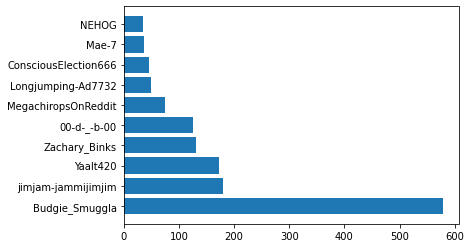

In [6]:
# Find average posts related to paypal per author
print(f"Unique authors: {df['Author'].nunique()}")
post_by_author = df['Author'].value_counts().reset_index()
post_by_author = post_by_author.rename(columns={'index':'author','Author':'cnt'})
plt.barh(post_by_author['author'][:10],post_by_author['cnt'][:10])
plt.show()

In [7]:
df.head()

,Date,Title,Snippet,Full Text,Sentiment,Emotion,Language,Author,Reddit Score,Reddit Score Upvote Ratio,Reddit Author Karma,Reddit Author Awardee Karma,Reddit Author Awarder Karma,Reddit Comments,Subreddit,Subreddit Subscribers
Unnamed: 0,,,,,,,,,,,,,,,,
2,2023-10-03 15:09:52.000,Overseas friend used my PayPal for his busines...,https://www.scamwatch.gov.au/ Send the info th...,https://www.scamwatch.gov.au/ Send the info th...,neutral,Anger,en,ahoneybadger3,1,NaN,147987,1035,137,NaN,paypal,49779
3,2023-10-03 14:39:05.000,Overseas friend used my PayPal for his busines...,"...debit/bank ones too, depending on their ban...","Your ""friend"" won't face any consequences what...",neutral,Anger,en,Yaalt420,1,NaN,1141,15,36,NaN,paypal,49779
4,2023-10-03 13:11:32.000,Will PayPal reveal the source of income (patre...,Let the man suck dick and get paid dude ....,Let the man suck dick and get paid dude ....,negative,Disgust,en,Shkro,1,NaN,6,0,34,NaN,paypal,49775
5,2023-10-03 12:33:04.000,Overseas friend used my PayPal for his busines...,"Hi all, I want to firstly say that I feel like...","Hi all, I want to firstly say that I feel like...",neutral,Anger,en,Southern_Win_3896,1,1.0,45,0,0,4.0,paypal,49779
7,2023-10-03 05:20:53.000,Someone sent me $300 through friends and famil...,"They have sent you nothing , Paypal is instant...","They have sent you nothing , Paypal is instant...",negative,Anger,en,Budgie_Smuggla,1,NaN,10655,40,0,NaN,paypal,49775


In [8]:
# Get some samples
sample_df = df.sample(n=5)

sample_posts = []
for i, row in sample_df.iterrows():
    reddit = f"Reddit {i}: {row['Full Text']}"
    print(reddit)
    print()
    

Reddit 4992: If you refund the wrong way (by sending refunds as payments instead of issuing refund from within the original transaction or being asked to withdraw and sending it to scammer in another method), you could end up out of money. Sender may have used stolen accounts to send payment and account holder is reporting unauthorized. Call PayPal and let them know the transactions are suspicious and unsolicited asking that they reverse them so you’re not charged fees. https://www.paypal.com/smarthelp/contact-us Scroll down to click “Message Us” or “Call Us” option on the bottom. Or reach out to PayPal at Facebook or Twitter: PayPal on Facebook: https://www.facebook.com/paypal PayPal on Twitter: https://www.twitter.com/paypal

Reddit 3626: They can fake it, not sure how because I'm not a scammer but I'm going to guess It's fairly easy. I remember there was an app to do it with phone numbers, you could call someone and it will look like someone else's phone number. I recently saw someo

### Tokenization

In [9]:
import re
import nltk
import random
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import bigrams, trigrams
from nltk.probability import FreqDist
from nltk.stem import PorterStemmer, WordNetLemmatizer

In [10]:
# Remove punctuation, stop words and frequent phrases
stop_words = set(stopwords.words('english'))
frequent_words = ["theyre","also","using","eat","food","I", "it", "U", "You", "He", "We", "They", "It", "She", "is", "was", "s","repost","➖"]

def preprocess(text):
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # Upon inspection, there are also presence of "XX", "XXX" and "XXX" used to sanitize sensitive information, 
    # need to remove them as well
    text = re.sub(r'x{2,4}', '', text)
    
    
    # Split the complaint into words
    words = text.split()
    # Remove stop words and frequent words
    words = [word for word in words if word.lower() not in frequent_words and word.lower() not in stop_words]
    # Join the remaining words back into a string
    preprocessed_text = ' '.join(words)
    return preprocessed_text
    

# Apply the preprocess_text_column function to the text column and store the result in a new column
df['processed_text'] = df['Full Text'].str.lower().apply(preprocess)

In [11]:
df['processed_text']

Unnamed: 0
2       httpswwwscamwatchgovau send info repeat scam s...
3       friend wont face consequences whatsoever far p...
4                         let man suck dick get paid dude
5       hi want firstly say feel like knowledgeable co...
7       sent nothing paypal instant probably part one ...
                              ...                        
4996    client scamming proof fake thats way paypal wo...
4997    im sus someone else privately message saying g...
4998    open new bank account link new account tasks r...
4999    probably dont want call since creating new acc...
5000    woul helpful let know need another reddit memb...
Name: processed_text, Length: 4991, dtype: object

In [209]:
# Perform stemming
def stemming(text):
    # Tokenize the text
    words = word_tokenize(text)
    
    # Perform stemming
    stemmer = PorterStemmer()
    stemmed_words = [stemmer.stem(word) for word in words]
    
    # Join the processed words back into a sentence
    stemmed_text = ' '.join(stemmed_words)
    return stemmed_text

# Apply the stemming function to the complaints column
df['Stemmed Text'] = df['processed_text'].apply(stemming)

In [210]:
df[['processed_text','Stemmed Text']]

,processed_text,Stemmed Text
Unnamed: 0,,
2,httpswwwscamwatchgovau send info repeat scam s...,httpswwwscamwatchgovau send info repeat scam s...
3,friend wont face consequences whatsoever far p...,friend wont face consequ whatsoev far paypal b...
4,let man suck dick get paid dude,let man suck dick get paid dude
5,hi want firstly say feel like knowledgeable co...,hi want firstli say feel like knowledg come sc...
7,sent nothing paypal instant probably part one ...,sent noth paypal instant probabl part one scam...
...,...,...
4996,client scamming proof fake thats way paypal wo...,client scam proof fake that way paypal work se...
4997,im sus someone else privately message saying g...,im su someon els privat messag say got scam pa...
4998,open new bank account link new account tasks r...,open new bank account link new account task re...


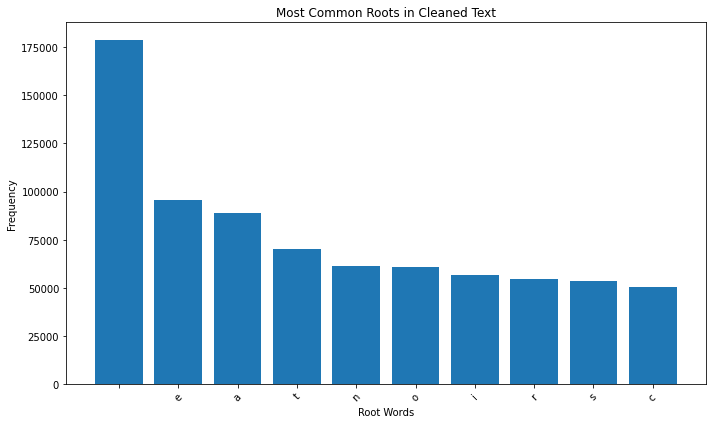

In [211]:
# Identify the most common roots in the cleaned text
import matplotlib.pyplot as plt
from collections import Counter

cleaned_words_stemmed = [stem for stems_list in df['Stemmed Text'] for stem in stems_list]

# Use Counter to count the frequency of each root
word_freq = Counter(cleaned_words_stemmed)

# Get the most common roots
most_common_roots = word_freq.most_common(10)  

# Extract the roots and their frequencies for plotting
roots, frequencies = zip(*most_common_roots)

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(roots, frequencies)
plt.xlabel('Root Words')
plt.ylabel('Frequency')
plt.title('Most Common Roots in Cleaned Text')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

In [299]:
vocab_size = 1000
from sklearn.feature_extraction.text import CountVectorizer
tf_vectorizer = CountVectorizer(max_df=0.7,
                                min_df=10,
                                stop_words=['paypal', 'fuck', 'dont', 'go', 'get', 'us', 'ive', 'day', 'im'],
                                max_features=vocab_size)

In [300]:
data = df['Stemmed Text'].tolist()
tf = tf_vectorizer.fit_transform(data)

In [303]:
num_topics = 10

from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=num_topics, random_state=0)
lda.fit(tf)

LatentDirichletAllocation(random_state=0)

In [304]:
lda.components_.sum(axis=1)

array([11746.96245466, 25326.33645666, 16597.43073176, 11615.10227129,
        9312.95085679, 21862.2426287 ,  8845.69219724, 10934.64945699,
       13494.09385091, 15368.53909498])

In [305]:
topic_word_distributions = np.array([row / row.sum() for row in lda.components_])

In [306]:
topic_word_distributions.shape

(10, 1000)

In [307]:
num_top_words = 20

def print_top_words(topic_word_distributions, num_top_words, vectorizer):
    vocab = vectorizer.get_feature_names()
    num_topics = len(topic_word_distributions)
    print('Displaying the top %d words per topic and their probabilities within the topic...' % num_top_words)
    print()

    for topic_idx in range(num_topics):
        print('[Topic ', topic_idx, ']', sep='')
        sort_indices = np.argsort(-topic_word_distributions[topic_idx])
        for rank in range(num_top_words):
            word_idx = sort_indices[rank]
            print(vocab[word_idx], ':',
                  topic_word_distributions[topic_idx, word_idx])
        print()

print_top_words(topic_word_distributions, num_top_words, tf_vectorizer)

Displaying the top 20 words per topic and their probabilities within the topic...

[Topic 0]
account : 0.03330198488214985
use : 0.01991701229715851
payment : 0.01985936942371515
protect : 0.016277394411335033
sell : 0.014427690645998454
reason : 0.013759512152315924
accept : 0.013000195447153667
creat : 0.011533921183684993
good : 0.011487775425687347
servic : 0.011193360482665627
polici : 0.010740632580579253
item : 0.010176278980605365
buyer : 0.010156769689952916
user : 0.010058020545459623
countri : 0.01002360712009166
ban : 0.009780624390904411
violat : 0.009603021358419608
seller : 0.009245269595896258
perman : 0.009063016447042518
fund : 0.008570909050568622

[Topic 1]
disput : 0.03147884395680179
seller : 0.02174635452944371
case : 0.019960907402312208
refund : 0.019716660045222552
back : 0.01849414892720527
buyer : 0.016305631265411093
item : 0.015703300647757722
bank : 0.01505999081949232
claim : 0.014254895497437593
money : 0.012619382940544457
close : 0.011523264740581256


In [308]:
doc_topic_matrix = lda.transform(tf)

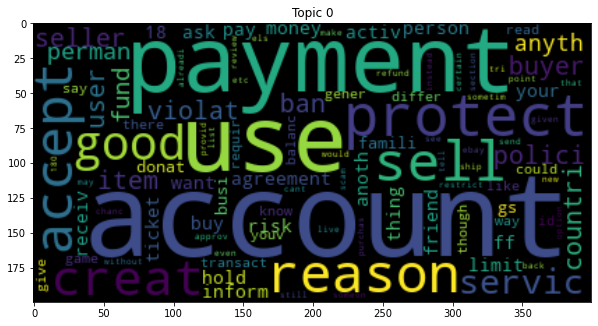

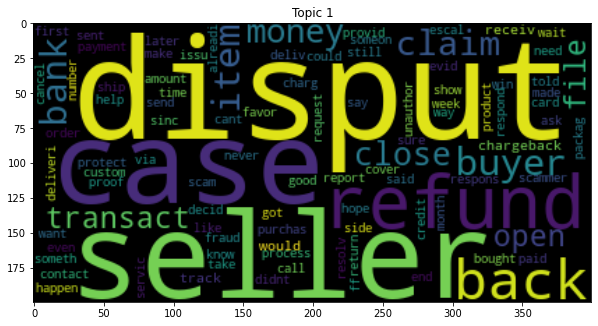

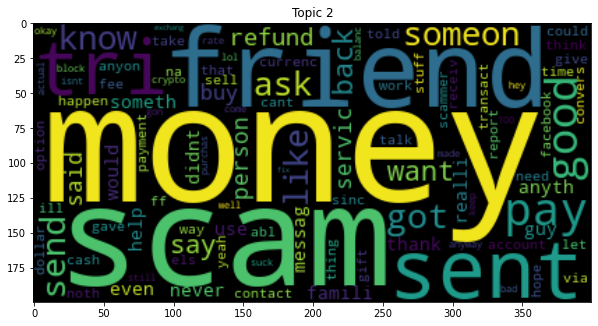

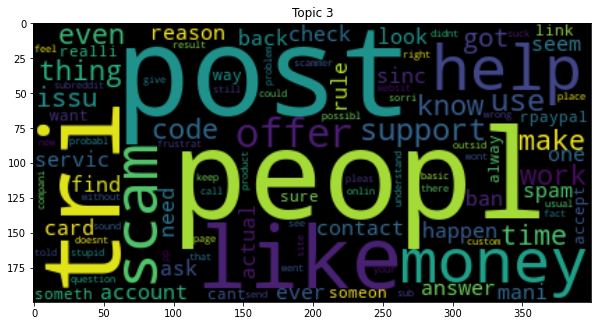

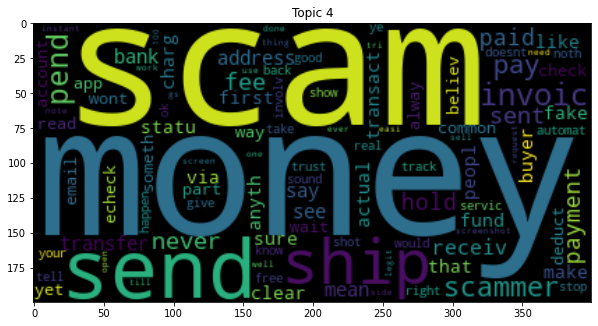

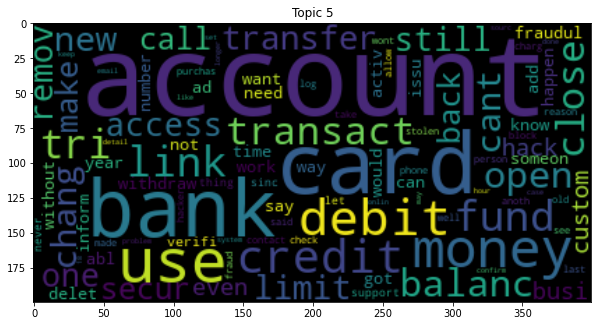

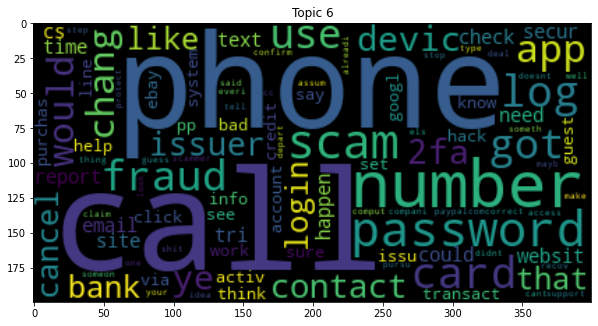

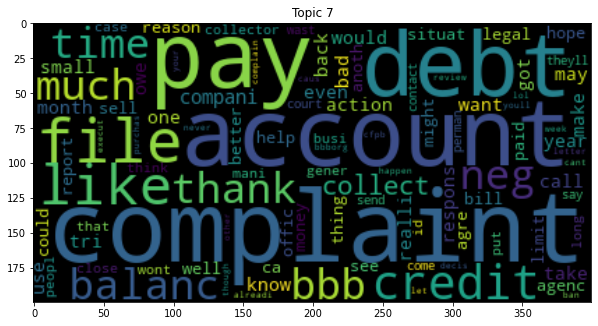

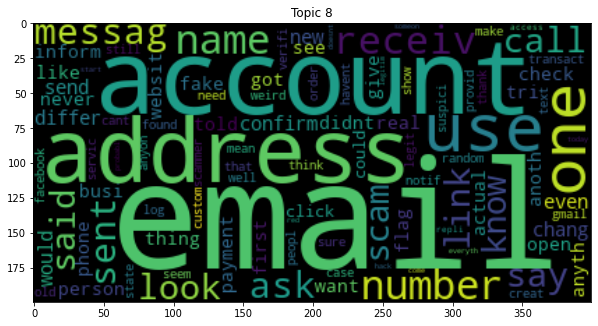

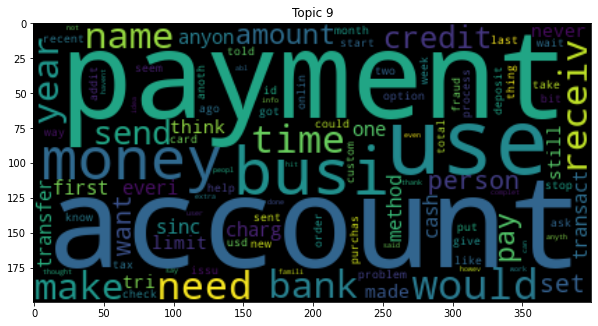

In [309]:
from wordcloud import WordCloud

num_max_word_cloud_words = 100

vocab = tf_vectorizer.get_feature_names()
num_topics = len(topic_word_distributions)

for topic_idx in range(num_topics):
    wc = WordCloud(max_words=num_max_word_cloud_words)
    wc.generate_from_frequencies(dict(zip(vocab, topic_word_distributions[topic_idx])))
    plt.figure(figsize=(10, 7))
    plt.imshow(wc, interpolation='bilinear')
    plt.title('Topic %d' % topic_idx)
    plt.show()

Topic 0: E-commerce and Business Transactions

Addresses account creation, payment policies, the relationship between sellers and buyers, and the acceptance criteria in e-commerce.

Topic 1: Financial Discrepancies & Claims

Focuses on disputes, refunds, transactions, chargebacks, and the relationship between buyers, sellers, and banks.

Topic 2: Peer-to-Peer Transactions & Interpersonal Experiences

Deals with money transfers among friends or acquaintances, experiences with scams, and interactions with individuals.

Topic 3: Community, Feedback & Experiences

Concerns the experiences of individuals in online communities, feedback posts, and general interactions.

Topic 4: Scams & Suspicious Transactions

Emphasizes scam-related issues, payments, shipping, and associated warnings.

Topic 5: Account Management & Banking

Discusses various aspects related to accounts, bank dealings, card transactions, and fund transfers.

Topic 6: Security & Personal Information

Focuses on account security, phone communication, scam alerts, and login details.

Topic 7: Financial Grievances & Reporting

Addresses complaints, credit scores, debt, and interactions with institutions such as the Better Business Bureau (BBB).

Topic 8: Email Communications & Identity

Deals with email-based interactions, potential scams, and identifying authentic communications.

Topic 9: Business Finance & Professional Transactions

Focuses on business payments, bank interactions, financial records, and credit matters in a professional or business setting.